In [1]:
key = '' #google api key
import requests
import json, os
import urllib.request
from shapely.geometry import Point, Polygon
from matplotlib import pyplot as plt
import shapely
import pickle
import random
import numpy as np
import gmaps

In [2]:
def plotMap(polyGrid, locations=[]):
    gPoly = []
    sLoc = []
    sHtext = []
    for k,v in polyGrid.items():
        gPoly.append(gmaps.Polygon(
                        list(v),
                        stroke_color='red',
                        fill_color='blue'
                        ))
        sLoc.append((v[0][0],v[0][1]))
        sHtext.append(str(k))
    
    if len(locations)!=0:
        sLoc = locations
        sHtext = list(map(lambda x:str(x), locations))
        
    fig = gmaps.figure(center=(39.50,-98.35), zoom_level=4, map_type='TERRAIN')
    fig.add_layer(gmaps.drawing_layer(features=gPoly))
    fig.add_layer(gmaps.symbol_layer(sLoc,info_box_content = sHtext, scale = 1))
    return fig

In [3]:
usaPolyGrid = pickle.load(open("usaPolyGrid.pkl",'rb'))
len(usaPolyGrid)

243

243


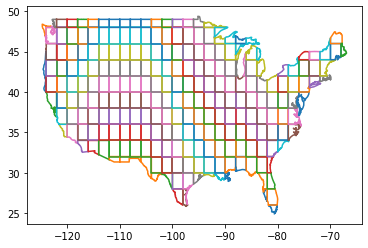

In [4]:
usaPolyGrid = pickle.load(open("usaPolyGrid.pkl",'rb'))
for i in usaPolyGrid.values():
    plt.plot(i[:,1],i[:,0])
print(len(usaPolyGrid))

1215

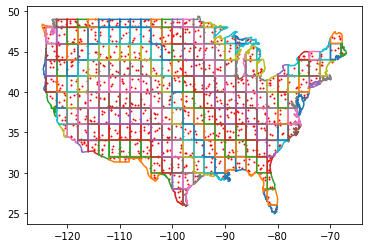

In [5]:
# %matplotlib auto
# %matplotlib inline
locs = []
for grid,coor in usaPolyGrid.items():
    poly = Polygon(np.flip(coor))
    x,y = poly.exterior.xy
    plt.plot(x,y)
    minx, miny, maxx, maxy = poly.bounds
    count = 0
    while count<5:
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if poly.contains(pnt):
            plt.scatter([pnt.x],[pnt.y],c='r',s=1)
            locs.append((pnt.y,pnt.x))
            count += 1
len(locs)

In [6]:
plotMap(usaPolyGrid, locations=locs)

Figure(layout=FigureLayout(height='420px'))

In [ ]:
searchGrids = usaPolyGrid.keys()
searchGrids = []
print("Seacrchin Grids: {}".format("All" if searchGrids==usaPolyGrid.keys() else searchGrids))

In [19]:
base = 'https://maps.googleapis.com/maps/api/streetview'
ext = '?size=600x300&location={}&fov=100&heading={}&radius={}&pitch=10&key={}'
print("Seacrchin Grids: {}".format("All" if searchGrids==usaPolyGrid.keys() else searchGrids))
for grid,coor in usaPolyGrid.items():        
    poly = Polygon(np.flip(coor))
    minx, miny, maxx, maxy = poly.bounds
    count = 0
    trials = 0
    locList = []
    if grid in searchGrids:
        saveFolder = 'data/{}'.format(grid)
        os.mkdir(saveFolder)
        print("Searching new grid {}".format(grid))
        while count<5 and trials<5:
            pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
            location = str(pnt.y)+','+str(pnt.x)
            if (poly.contains(pnt)) and (location not in locList):
                metaUrl = base + '/metadata' + ext.format(location, 0, 10000, key)
                r = requests.get(metaUrl).json()
                trials += 1
                print("Trial: {}, count: {}".format(trials,count))
                if r['status']=='OK' and poly.contains(Point(r['location']['lng'],r['location']['lat'])):
                    location = str(r['location']['lat'])+','+str(r['location']['lng'])
                    print("Valid location found: {}".format(location))
                    locList.append(location)
                    saveFile = saveFolder + "/{}".format(location)
                    if os.path.exists(saveFile)==False:
                        os.mkdir(saveFile)

                    for heading in [0,90,180]:
                        imgUrl = base + ext.format(location, heading, 10000, key)
                        urllib.request.urlretrieve(imgUrl,saveFile+'/{}_{}.jpg'.format(heading,r['date']))
                    count += 1
                    trials = 0
                else:
                    print("Failed trial")
#         i = input("Completed grid {}:".format(grid))
#         if i=='0':
#             break
    else:
        print("Skipping grid: {}".format(grid))

Skipping Grids ['0', '1']
Grid 0 already has data
Grid 1 already has data
Searching new grid 2
Trial: 1, count: 0
Valid location found: 37.9622365,-122.6241516
Trial: 1, count: 1
Valid location found: 39.9127513277149,-122.2790158471827
Trial: 1, count: 2
Valid location found: 39.4459121,-123.7178844
Trial: 1, count: 3
Valid location found: 39.10868190000001,-123.498785
Trial: 1, count: 4
Valid location found: 39.03206,-123.2715315
Searching new grid 3
Trial: 1, count: 0
Failed trial
Trial: 2, count: 0
Valid location found: 40.1423424,-123.8190157
Trial: 1, count: 1
Valid location found: 41.8587661,-122.7512298
Trial: 1, count: 2
Valid location found: 41.86847202907784,-123.2995912903561
Trial: 1, count: 3
Valid location found: 40.3979869,-122.5219585
Trial: 1, count: 4
Valid location found: 41.54169821357193,-122.5958111167321
Searching new grid 4
Trial: 1, count: 0
Valid location found: 42.15260313499462,-123.4011855848939
Trial: 1, count: 1
Valid location found: 42.56298487509426,-1

Searching new grid 22
Trial: 1, count: 0
Valid location found: 46.15871365366496,-118.9426706380517
Trial: 1, count: 1
Valid location found: 46.6489227039028,-119.875016835034
Trial: 1, count: 2
Valid location found: 47.3807726,-119.9409437
Trial: 1, count: 3
Valid location found: 47.39851967250983,-119.2771867066926
Trial: 1, count: 4
Valid location found: 46.64477661312578,-118.2489851933969
Searching new grid 23
Trial: 1, count: 0
Valid location found: 48.94095354059183,-118.822334101653
Trial: 1, count: 1
Valid location found: 48.7926831,-119.0578774
Trial: 1, count: 2
Valid location found: 48.97499339388145,-118.7615578384666
Trial: 1, count: 3
Valid location found: 48.65659361625011,-119.3190703069027
Trial: 1, count: 4
Valid location found: 48.1621842,-118.9015966
Searching new grid 24
Trial: 1, count: 0
Valid location found: 33.59858232592157,-116.1101779934216
Trial: 1, count: 1
Valid location found: 33.7833589,-116.2869899
Trial: 1, count: 2
Valid location found: 33.6185039,-

Trial: 1, count: 4
Valid location found: 48.53360299618364,-114.565657960216
Searching new grid 42
Trial: 1, count: 0
Failed trial
Trial: 2, count: 0
Valid location found: 32.82518952073718,-113.441299283982
Trial: 1, count: 1
Valid location found: 33.08869526230842,-112.2718742417178
Trial: 1, count: 2
Valid location found: 32.1767616103551,-112.1912737447964
Trial: 1, count: 3
Valid location found: 33.69381538804475,-112.8563409221511
Trial: 1, count: 4
Valid location found: 32.8650257435563,-113.15919824864
Searching new grid 43
Trial: 1, count: 0
Valid location found: 34.34920593272081,-112.1688896515807
Trial: 1, count: 1
Valid location found: 34.8217979,-112.7101092
Trial: 1, count: 2
Valid location found: 35.2934641,-112.7359117
Trial: 1, count: 3
Failed trial
Trial: 2, count: 3
Valid location found: 35.8767084,-113.9820958
Trial: 1, count: 4
Valid location found: 34.5652171651216,-112.2799113051378
Searching new grid 44
Trial: 1, count: 0
Valid location found: 37.36744297193053

Trial: 1, count: 3
Valid location found: 31.89870489999999,-108.4967139
Trial: 1, count: 4
Valid location found: 31.9180918,-109.2811683
Searching new grid 62
Trial: 1, count: 0
Failed trial
Trial: 2, count: 0
Valid location found: 33.56329772343194,-108.6885045212318
Trial: 1, count: 1
Valid location found: 32.02250988824742,-108.3366944675871
Trial: 1, count: 2
Valid location found: 32.21502149125019,-109.1761356916849
Trial: 1, count: 3
Valid location found: 32.18896464381243,-109.6867508780065
Trial: 1, count: 4
Valid location found: 33.71905634706555,-108.9335393630971
Searching new grid 63
Trial: 1, count: 0
Failed trial
Trial: 2, count: 0
Failed trial
Trial: 3, count: 0
Valid location found: 34.3679915,-108.5336789
Trial: 1, count: 1
Valid location found: 34.13952498597003,-108.4976564363025
Trial: 1, count: 2
Valid location found: 35.7871114,-108.5578679
Trial: 1, count: 3
Valid location found: 35.59965290359037,-109.7497300053594
Trial: 1, count: 4
Valid location found: 35.707

Trial: 2, count: 0
Failed trial
Trial: 3, count: 0
Valid location found: 48.37582766910496,-107.7916793186745
Trial: 1, count: 1
Failed trial
Trial: 2, count: 1
Failed trial
Trial: 3, count: 1
Valid location found: 48.80234321622428,-107.85747181706
Trial: 1, count: 2
Valid location found: 48.3694539625664,-107.9672428289569
Trial: 1, count: 3
Failed trial
Trial: 2, count: 3
Valid location found: 48.2616507818219,-107.9699164068476
Trial: 1, count: 4
Failed trial
Trial: 2, count: 4
Failed trial
Trial: 3, count: 4
Valid location found: 48.27326547010134,-106.7856896616717
Searching new grid 81
Trial: 1, count: 0
Failed trial
Trial: 2, count: 0
Failed trial
Trial: 3, count: 0
Failed trial
Trial: 4, count: 0
Valid location found: 30.89538844074055,-104.7951149773647
Trial: 1, count: 1
Valid location found: 31.1224937420489,-105.1787234613925
Trial: 1, count: 2
Valid location found: 31.07193040925865,-104.1320361957339
Trial: 1, count: 3
Valid location found: 31.86251410529854,-104.2616197

Trial: 1, count: 2
Valid location found: 42.47961886334244,-102.4411715680005
Trial: 1, count: 3
Valid location found: 43.43265323273939,-102.1516029097579
Trial: 1, count: 4
Valid location found: 42.15374357449977,-103.8105539238345
Searching new grid 99
Trial: 1, count: 0
Valid location found: 44.423832,-103.234189
Trial: 1, count: 1
Failed trial
Trial: 2, count: 1
Failed trial
Trial: 3, count: 1
Failed trial
Trial: 4, count: 1
Failed trial
Trial: 5, count: 1
Valid location found: 44.11284488603889,-102.4879886586116
Trial: 1, count: 2
Valid location found: 45.3837169,-102.8150976
Trial: 1, count: 3
Valid location found: 45.5016209,-103.9887706
Trial: 1, count: 4
Failed trial
Trial: 2, count: 4
Valid location found: 45.02302375116517,-102.7470853087889
Searching new grid 100
Trial: 1, count: 0
Valid location found: 47.79338892311921,-103.2215075342194
Trial: 1, count: 1
Failed trial
Trial: 2, count: 1
Valid location found: 47.74757756822456,-102.9423887264424
Trial: 1, count: 2
Faile

Trial: 1, count: 3
Valid location found: 34.5083084,-99.7712288
Trial: 1, count: 4
Valid location found: 35.1853942,-99.6420409
Searching new grid 118
Trial: 1, count: 0
Valid location found: 36.44761101929792,-98.4263858097536
Trial: 1, count: 1
Valid location found: 37.54758547791894,-99.65290629202482
Trial: 1, count: 2
Valid location found: 36.30427573114007,-98.56612696196406
Trial: 1, count: 3
Valid location found: 36.797801,-99.35083
Trial: 1, count: 4
Valid location found: 36.39084189134777,-98.3749588188945
Searching new grid 119
Trial: 1, count: 0
Valid location found: 38.721089,-98.485889
Trial: 1, count: 1
Valid location found: 39.45743943244308,-99.84502483680261
Trial: 1, count: 2
Valid location found: 39.61068222724032,-99.21176356236492
Trial: 1, count: 3
Valid location found: 39.4081668,-98.4262605
Trial: 1, count: 4
Valid location found: 39.0833457,-99.8700379
Searching new grid 120
Trial: 1, count: 0
Valid location found: 41.04318908311366,-99.67414679980497
Trial: 1

Searching new grid 138
Trial: 1, count: 0
Valid location found: 31.68835420527765,-94.75262626598219
Trial: 1, count: 1
Valid location found: 30.51210395353393,-94.02538005571084
Trial: 1, count: 2
Valid location found: 31.75426938942665,-95.58865453162171
Trial: 1, count: 3
Valid location found: 31.12923320622779,-95.67513574858678
Trial: 1, count: 4
Valid location found: 31.41492382110169,-94.61028835860596
Searching new grid 139
Trial: 1, count: 0
Valid location found: 32.30557308212272,-94.9978005432703
Trial: 1, count: 1
Valid location found: 32.29249368116736,-94.96486059174894
Trial: 1, count: 2
Valid location found: 33.95329245017936,-95.64093454028034
Trial: 1, count: 3
Valid location found: 33.51492756409213,-95.37936164147966
Trial: 1, count: 4
Valid location found: 33.36662047372221,-94.69164300613184
Searching new grid 140
Trial: 1, count: 0
Valid location found: 34.27251642532683,-94.80562363542786
Trial: 1, count: 1
Valid location found: 34.29398276099428,-95.66075058351

Trial: 1, count: 0
Valid location found: 48.10922240441768,-90.8322055929552
Trial: 1, count: 1
Valid location found: 48.1696434,-92.49131009999999
Trial: 1, count: 2
Valid location found: 48.1169165915723,-93.90427422299233
Trial: 1, count: 3
Valid location found: 48.0143967,-91.3066559
Trial: 1, count: 4
Valid location found: 48.19106502397983,-93.73858652685448
Searching new grid 159
Trial: 1, count: 0
Valid location found: 29.7785202,-90.3964375
Trial: 1, count: 1
Valid location found: 29.5485762,-90.6871794
Trial: 1, count: 2
Valid location found: 29.3424364,-90.2469436
Trial: 1, count: 3
Valid location found: 29.83269957093732,-91.51651429772485
Trial: 1, count: 4
Valid location found: 29.78225220363828,-91.46039641730323
Searching new grid 160
Trial: 1, count: 0
Valid location found: 31.44787263087694,-91.69766302043062
Trial: 1, count: 1
Valid location found: 30.26195054860472,-91.32337878056843
Trial: 1, count: 2
Valid location found: 30.04812477466416,-90.27628111364687
Trial

Trial: 1, count: 1
Valid location found: 45.77672887952514,-89.7969225929644
Trial: 1, count: 2
Valid location found: 45.87417817164324,-89.5213506334033
Trial: 1, count: 3
Valid location found: 45.00391564707536,-88.2144034093393
Trial: 1, count: 4
Valid location found: 44.46810633063663,-88.52081601250856
Searching new grid 179
Trial: 1, count: 0
Valid location found: 46.58103366921007,-89.39616725017946
Trial: 1, count: 1
Valid location found: 47.18697266949773,-88.58462990887486
Trial: 1, count: 2
Valid location found: 47.07512275025877,-88.63882160472347
Trial: 1, count: 3
Valid location found: 46.8428767515727,-89.27089870663096
Trial: 1, count: 4
Valid location found: 46.18593416500748,-88.41491333261152
Searching new grid 180
Trial: 1, count: 0
Valid location found: 31.53791635636415,-86.38655380675364
Trial: 1, count: 1
Valid location found: 31.63351048723513,-86.62676762685865
Trial: 1, count: 2
Valid location found: 31.40809961664258,-87.74433195682295
Trial: 1, count: 3
Val

Trial: 1, count: 3
Valid location found: 45.44186306549641,-84.74174942483634
Trial: 1, count: 4
Valid location found: 44.44462184945821,-85.07485011373466
Searching new grid 199
Trial: 1, count: 0
Valid location found: 46.36911047820564,-84.55143652653545
Trial: 1, count: 1
Valid location found: 46.40066749832907,-84.73907329604377
Trial: 1, count: 2
Valid location found: 46.39701705332953,-84.54080604927887
Trial: 1, count: 3
Valid location found: 46.37959506324247,-84.96953058062415
Trial: 1, count: 4
Valid location found: 46.14982434730626,-85.92769510487985
Searching new grid 200
Trial: 1, count: 0
Valid location found: 27.64142415728769,-82.39104358517358
Trial: 1, count: 1
Valid location found: 27.42013530374862,-82.31002877624086
Trial: 1, count: 2
Valid location found: 27.9288247,-82.15577669999999
Trial: 1, count: 3
Failed trial
Trial: 2, count: 3
Valid location found: 27.4276894,-82.3284442
Trial: 1, count: 4
Valid location found: 27.5673363,-82.1046101
Searching new grid 20

Trial: 1, count: 4
Valid location found: 41.52281729474097,-81.58856527669786
Searching new grid 219
Trial: 1, count: 0
Valid location found: 33.75832763053013,-79.57876392043231
Trial: 1, count: 1
Valid location found: 33.95952473095299,-79.95464561480657
Trial: 1, count: 2
Valid location found: 33.251024,-79.269404
Trial: 1, count: 3
Valid location found: 32.90544242773024,-79.92137394900101
Trial: 1, count: 4
Valid location found: 33.42666515212088,-79.34624522707786
Searching new grid 220
Trial: 1, count: 0
Valid location found: 34.20495803327629,-79.31995914837965
Trial: 1, count: 1
Valid location found: 35.21006983641784,-78.85959008068323
Trial: 1, count: 2
Valid location found: 35.53179559927986,-79.15935807121602
Trial: 1, count: 3
Valid location found: 35.76891829115488,-78.27329552977353
Trial: 1, count: 4
Valid location found: 34.61548842832077,-79.49299252572266
Searching new grid 221
Trial: 1, count: 0
Valid location found: 36.70103128411242,-78.65569997976795
Trial: 1, c

Trial: 1, count: 1
Valid location found: 44.8885478,-71.0339985
Trial: 1, count: 2
Valid location found: 44.0784982,-71.70201089999999
Trial: 1, count: 3
Failed trial
Trial: 2, count: 3
Valid location found: 44.94839352413933,-71.40695368845837
Trial: 1, count: 4
Failed trial
Trial: 2, count: 4
Valid location found: 45.4769381,-70.0651004
Searching new grid 240
Trial: 1, count: 0
Valid location found: 45.7156206,-68.5939861
Trial: 1, count: 1
Valid location found: 45.7736433,-68.5658298
Trial: 1, count: 2
Valid location found: 45.98641629999999,-68.8851008
Trial: 1, count: 3
Failed trial
Trial: 2, count: 3
Valid location found: 44.939795407428,-68.84394313528144
Trial: 1, count: 4
Valid location found: 45.65778138365464,-68.10193326932912
Searching new grid 241
Trial: 1, count: 0
Failed trial
Trial: 2, count: 0
Valid location found: 46.9003456565648,-68.13327848502321
Trial: 1, count: 1
Valid location found: 46.30735511688403,-69.08352945059019
Trial: 1, count: 2
Failed trial
Trial: 2,

In [20]:
gdsLoc = {}
for g in os.listdir("data"):
    gdsLoc[int(g)] = []
    for loc in os.listdir("data/{}".format(g)):
        gdsLoc[int(g)].append(list(map(lambda x:float(x),loc.split(','))))

In [24]:
for k,v in gdsLoc.items():
    if len(v)<5:
        print(k)

79
111
29


In [25]:
gPoly = []
sLoc = []
sHtext = []
restrict = list(gdsLoc.keys())
restrict = [79,111,29]
for k,v in gdsLoc.items():
    if k in restrict:
        gPoly.append(gmaps.Polygon(
                        list(usaPolyGrid[k]),
                        stroke_color='red',
                        fill_color='blue'
                        ))
        sLoc += v
        sHtext += [str(i) for i in v]
fig = gmaps.figure(center=(39.50,-98.35), zoom_level=4, map_type='TERRAIN')
fig.add_layer(gmaps.drawing_layer(features=gPoly))
fig.add_layer(gmaps.symbol_layer(sLoc,info_box_content = sHtext, scale = 2))
fig

Figure(layout=FigureLayout(height='420px'))

In [8]:
# location = '46.514382,10.013988'
# heading = 360
# radius = 10000
# base = 'https://maps.googleapis.com/maps/api/streetview'
# ext = '?size=600x300&location={}&fov=100&heading={}&radius={}&pitch=10&key={}'.format(location,
#                                                                                       heading,
#                                                                                       radius,
#                                                                                       key)
# imgUrl = base + ext
# metaUrl = base + '/metadata' + ext
# requests.get(metaUrl).json()

{'error_message': 'This functionality is only available if an API key or a client ID is provided: /metadata',
 'status': 'REQUEST_DENIED'}